In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
import torch.nn.functional as F


Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[paper](https://arxiv.org/pdf/1611.07308.pdf)  
[code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

## Graph AutoEncoder GAE

### Load the data

In [ ]:
dataset = Planetoid(".", "CiteSeer", transform=T.NormalizeFeatures())
dataset.data

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:188: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [ ]:
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327])

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('===========================================================================================================')

# # Gather some statistics about the graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327])


In [ ]:
data = train_test_split_edges(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning
        self.conv3 = GCNConv(out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)#.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv3(x, edge_index)

        return x

### Define the Autoencoder

In [ ]:
from torch_geometric.nn import GAE

In [ ]:
# parameters
out_channels = 64
num_features = dataset.num_features
epochs = 300

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)



before training :

In [ ]:
Z = model.encode(x, train_pos_edge_index)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/GAE0_embedding')

writer.add_embedding(
    Z,
    metadata=data.y,global_step=1)


In [ ]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

<IPython.core.display.Javascript object>

Epoch: 001, AUC: 0.6708, AP: 0.6850
Epoch: 002, AUC: 0.6532, AP: 0.6709
Epoch: 003, AUC: 0.6551, AP: 0.6984
Epoch: 004, AUC: 0.6496, AP: 0.7069
Epoch: 005, AUC: 0.6422, AP: 0.7052
Epoch: 006, AUC: 0.6379, AP: 0.7086
Epoch: 007, AUC: 0.6636, AP: 0.7219
Epoch: 008, AUC: 0.7437, AP: 0.7607
Epoch: 009, AUC: 0.7696, AP: 0.7779
Epoch: 010, AUC: 0.7954, AP: 0.7995
Epoch: 011, AUC: 0.7911, AP: 0.7988
Epoch: 012, AUC: 0.7929, AP: 0.7960
Epoch: 013, AUC: 0.7688, AP: 0.7785
Epoch: 014, AUC: 0.7996, AP: 0.8030
Epoch: 015, AUC: 0.8015, AP: 0.7996
Epoch: 016, AUC: 0.8073, AP: 0.8086
Epoch: 017, AUC: 0.7964, AP: 0.8007
Epoch: 018, AUC: 0.8154, AP: 0.8168
Epoch: 019, AUC: 0.8277, AP: 0.8231
Epoch: 020, AUC: 0.8299, AP: 0.8232
Epoch: 021, AUC: 0.8431, AP: 0.8389
Epoch: 022, AUC: 0.8503, AP: 0.8483
Epoch: 023, AUC: 0.8522, AP: 0.8493
Epoch: 024, AUC: 0.8562, AP: 0.8499
Epoch: 025, AUC: 0.8520, AP: 0.8443
Epoch: 026, AUC: 0.8496, AP: 0.8438
Epoch: 027, AUC: 0.8558, AP: 0.8491
Epoch: 028, AUC: 0.8561, AP:

In [ ]:
Z = model.encode(x, train_pos_edge_index)
Z.shape

torch.Size([3327, 64])

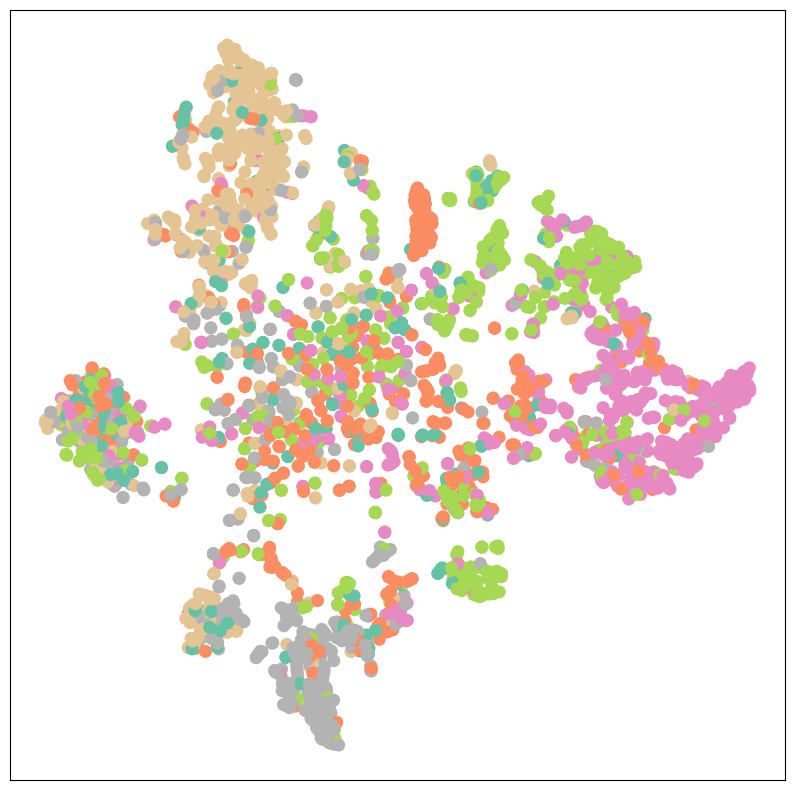

In [ ]:
visualize(Z, color=data.y)

In [ ]:
# if batch_idx == 230:
writer = SummaryWriter('runs/GAE1_embedding')

writer.add_embedding(
    Z,
    metadata=data.y,global_step=1)


    #label_img=data.y)#,
    #global_step=batc#h_idx)

# Use Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir runs

---
----

## Load our dataset :

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.utils import train_test_split_edges
import torch.nn.functional as F
import numpy as np

1. adjacency martix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weighted_adjacency_matrix = np.load('/content/drive/My Drive/Data/ProcessedData/World.npy')

In [ ]:
weighted_adjacency_matrix[weighted_adjacency_matrix < 0.7] = 0

In [ ]:
edge_index = np.array(weighted_adjacency_matrix.nonzero())
np.shape(edge_index)

(2, 1593550)

2. feature matrix

In [ ]:
feature_matrix = np.load('/content/drive/My Drive/Data/ProcessedData/World/features/final feature mat/feature_mat3.npy')
feature_matrix = np.nan_to_num(feature_matrix)

In [ ]:
from torch_geometric.data import Data

In [ ]:
# Convert the adjacency matrix to a COO format
edge_index = np.array(weighted_adjacency_matrix.nonzero())#.t()
np.shape(edge_index)

(2, 1593550)

In [ ]:

# Convert the feature matrix to PyTorch tensor
x = torch.tensor(feature_matrix, dtype=torch.float)

# Create the PyG Data object
data = Data(x=x, edge_index=edge_index)#,edge_weight=np.random.randn(100))

# Print the created Data object
print(data)

Data(x=[5418, 484], edge_index=[2, 1593550])


In [ ]:
temp = data.edge_index
temp = np.transpose(temp)

In [ ]:
edges = []
for i,j in temp:
    if i != j:
        edges.append((i,j))

In [ ]:
edges = np.transpose(edges)
edges.shape

(2, 1588132)

In [ ]:
weights = []
for i,j in np.transpose(data.edge_index):
    # print(i,j)
    if i!=j:
        weights.append(weighted_adjacency_matrix[i,j])


In [ ]:
weights = np.array(weights)
weights.shape, weights[0]

((1588132,), 0.7061117757345389)

In [ ]:
edge_weights = torch.concat((torch.tensor(weights).unsqueeze(1),torch.tensor(weights).unsqueeze(1)),axis=-1)

In [ ]:
# Convert the feature matrix to PyTorch tensor
x = torch.tensor(feature_matrix, dtype=torch.float)

# Create the PyG Data object
data = Data(x=x, edge_index=torch.tensor(edges),edge_attr=edge_weights)

# Print the created Data object
print(data)

Data(x=[5418, 484], edge_index=[2, 1588132], edge_attr=[1588132, 2])


In [ ]:
# Save the Data object
# torch.save(data, 'data.pt')

In [ ]:

# Load the Data object
# data = torch.load('data.pt')

# print(data)

---

In [ ]:
data = train_test_split_edges(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
print(data)

Data(x=[5418, 484], val_pos_edge_index=[2, 39703], val_pos_edge_attr=[39703, 2], test_pos_edge_index=[2, 79406], test_pos_edge_attr=[79406, 2], train_pos_edge_index=[2, 1349914], train_pos_edge_attr=[1349914, 2], train_neg_adj_mask=[5418, 5418], val_neg_edge_index=[2, 39703], test_neg_edge_index=[2, 79406])


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GATConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning
        self.conv3 = GATConv(out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)

        return x

### Define the Autoencoder

In [ ]:
from torch_geometric.nn import GAE

In [ ]:
# parameters
out_channels = 64
num_features = data.x.shape[1]
epochs = 50

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)



In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

    # writer.add_scalar('auc train',auc,epoch) # new line
    # writer.add_scalar('ap train',ap,epoch)   # new line

<IPython.core.display.Javascript object>

Epoch: 001, AUC: 0.3358, AP: 0.3839
Epoch: 002, AUC: 0.5873, AP: 0.4898
Epoch: 003, AUC: 0.8004, AP: 0.6479
Epoch: 004, AUC: 0.8751, AP: 0.7510
Epoch: 005, AUC: 0.8754, AP: 0.7502
Epoch: 006, AUC: 0.8923, AP: 0.7842
Epoch: 007, AUC: 0.8961, AP: 0.7976
Epoch: 008, AUC: 0.9217, AP: 0.8559
Epoch: 009, AUC: 0.9298, AP: 0.8778
Epoch: 010, AUC: 0.9571, AP: 0.9358
Epoch: 011, AUC: 0.9675, AP: 0.9559
Epoch: 012, AUC: 0.9684, AP: 0.9569
Epoch: 013, AUC: 0.9661, AP: 0.9545
Epoch: 014, AUC: 0.9653, AP: 0.9521
Epoch: 015, AUC: 0.9631, AP: 0.9476
Epoch: 016, AUC: 0.9524, AP: 0.9309
Epoch: 017, AUC: 0.9388, AP: 0.9044
Epoch: 018, AUC: 0.9358, AP: 0.8985
Epoch: 019, AUC: 0.9345, AP: 0.8958
Epoch: 020, AUC: 0.9443, AP: 0.9203
Epoch: 021, AUC: 0.9518, AP: 0.9357
Epoch: 022, AUC: 0.9537, AP: 0.9392
Epoch: 023, AUC: 0.9614, AP: 0.9467
Epoch: 024, AUC: 0.9676, AP: 0.9501
Epoch: 025, AUC: 0.9632, AP: 0.9430
Epoch: 026, AUC: 0.9654, AP: 0.9464
Epoch: 027, AUC: 0.9453, AP: 0.9156
Epoch: 028, AUC: 0.9482, AP:

In [ ]:
Z = model.encode(x, train_pos_edge_index)
Z.shape

torch.Size([5418, 64])

In [ ]:
torch.save(Z, '/content/drive/My Drive/Data/Node Embeddings/node_embedding8.2.pt')

In [ ]:
# visualize(Z, color=data.y)

In [ ]:
# writer = SummaryWriter('runs/GAE1_embedding')

# writer.add_embedding(
#     Z,
#     metadata=data.y,global_step=1)